In [74]:
import dask.dataframe as dd
from IPython.display import display
import numpy as np
import pickle
import matplotlib.pyplot as plt
import ast
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.ndimage import binary_dilation
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from joblib import Parallel, delayed
def log_func(x, a, b, c):
    return a * np.log(x + b) + c

In [75]:
def analyze_matrix(pickle_data):
    matrix = np.zeros((len(pickle_data['param_values_list_combination'][0]), len(pickle_data['param_values_list_combination'][1])))
    matrix2 = np.zeros((len(pickle_data['param_values_list_combination'][0]), len(pickle_data['param_values_list_combination'][1])))
    def process_resource(i, resource_value):
        ddf = dd.read_parquet(parquet_file_path, engine='pyarrow', 
                        include_partition_columns=True, 
                        gather_statistics=True, 
                        dtype_backend='pyarrow', 
                        filters=[("Resources", "==", str(resource_value))])
        local_matrix = np.zeros(len(pickle_data['param_values_list_combination'][1]))
        local_matrix2 = np.zeros(len(pickle_data['param_values_list_combination'][1]))
        for j, phage_value in enumerate(pickle_data['param_values_list_combination'][1]):
            # print("processing resource", i, "phage", j)
            simulation_results = ddf.query(f'Phages == {phage_value}').compute()
            y_values = np.array(ast.literal_eval(simulation_results['y_values'].iloc[0]))[-1, :]
            print(np.max(y_values))
            if np.any(y_values > phage_value * 2):
                local_matrix[j] = np.max(y_values)
                local_matrix2[j] = 1
        return local_matrix, local_matrix2

    results = Parallel(n_jobs=-1)(
        delayed(process_resource)(i, resource_value)
        for i, resource_value in enumerate(pickle_data['param_values_list_combination'][0])
    )

    for i, (col, col2) in enumerate(results):
        matrix[i, :] = col
        print(matrix)
        matrix2[i, :] = col2
    matrix = matrix.T
    matrix2 = matrix2.T
    print(matrix, matrix2
    )
    return matrix, matrix2

In [85]:
def create_plot(matrix, matrix2, pickle_data, save_fig=None, plot_curve_fit=True):
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.figure(figsize=(10, 6))
    plt.imshow(matrix, aspect='auto', origin='lower', cmap='viridis')

    # Create a custom colormap: black for 0, red to green for >0
    colors = ['white'] + [plt.cm.Reds(i) for i in np.linspace(0.2, 1, 255)]
    cmap = ListedColormap(colors)
    bounds = [0, 1e-10] + list(np.linspace(matrix[matrix > 0].min(), matrix.max(), 255))
    norm = BoundaryNorm(bounds, cmap.N)

    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Max Phage Population Reached', ax=plt.gca())
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label('Max Phage Population Reached', fontsize=14)
    plt.imshow(matrix, aspect='auto', origin='lower', cmap=cmap, norm=norm)
    plt.xlabel('Resources', fontsize=14)
    plt.ylabel('Phages', fontsize=14)
    plt.title('Max Y Values For Phages If Proliferated \n Else 0 If Not Proliferated', fontsize=16)
    xtick_indices = np.arange(0, len(pickle_data['param_values_list_combination'][0]), 5)
    xtick_labels = [f"{v:.3f}" for v in np.array(pickle_data['param_values_list_combination'][0])[xtick_indices]]
    ytick_indices = np.arange(0, len(pickle_data['param_values_list_combination'][1]), 5)
    ytick_labels = [f"{v:.3f}" for v in np.array(pickle_data['param_values_list_combination'][1])[ytick_indices]]
    plt.xticks(ticks=xtick_indices, labels=xtick_labels, rotation=90, fontsize=12)
    plt.yticks(ticks=ytick_indices, labels=ytick_labels, fontsize=12)
    if save_fig != None:
        plt.savefig(f'LatexReport/Images/Plots/Created/PP/{save_fig}', dpi=300, bbox_inches='tight')

parameter_names_used ['Resources', 'Phages']
param_values_list_combination [[1.0, 7.3164556962025316, 13.632911392405063, 19.949367088607595, 26.265822784810126, 32.58227848101266, 38.89873417721519, 45.21518987341772, 51.53164556962025, 57.848101265822784, 64.16455696202532, 70.48101265822785, 76.79746835443038, 83.1139240506329, 89.43037974683544, 95.74683544303798, 102.0632911392405, 108.37974683544303, 114.69620253164557, 121.0126582278481, 127.32911392405063, 133.64556962025316, 139.9620253164557, 146.27848101265823, 152.59493670886076, 158.91139240506328, 165.2278481012658, 171.54430379746836, 177.86075949367088, 184.1772151898734, 190.49367088607596, 196.81012658227849, 203.126582278481, 209.44303797468353, 215.75949367088606, 222.0759493670886, 228.39240506329114, 234.70886075949366, 241.0253164556962, 247.34177215189874, 253.65822784810126, 259.9746835443038, 266.2911392405063, 272.60759493670884, 278.9240506329114, 285.24050632911394, 291.55696202531647, 297.873417721519, 304

<Figure size 640x480 with 0 Axes>

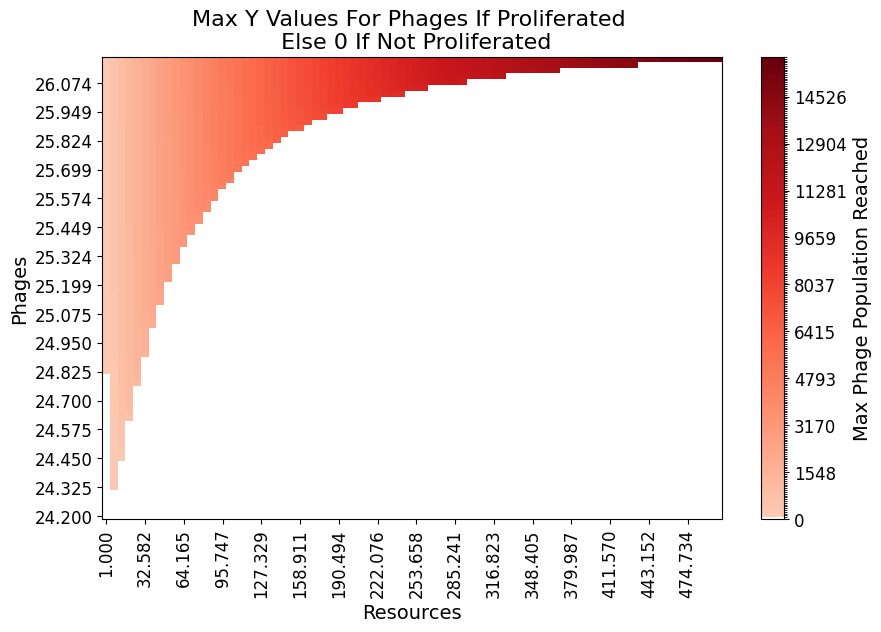

In [87]:
parquet_file_path = 'SimulationResults/UltimateAnalysis/PhasePortraitResourcesPhage/PhasePortraitResourcesPhage.parquet'
pickle_file_path = 'SimulationResults/UltimateAnalysis/PhasePortraitResourcesPhage/PhasePortraitResourcesPhage.pickle'

with open(pickle_file_path, 'rb') as f:
    pickle_data = pickle.load(f)
print("parameter_names_used", pickle_data['parameter_names_used'])
print("param_values_list_combination", pickle_data['param_values_list_combination'])
print('partition_data', pickle_data['agent_type_count'])
print("agent_type", pickle_data['agent_type'])
print("agent_names", pickle_data['agent_names'])

matrix, matrix2 = analyze_matrix(pickle_data)
create_plot(matrix, matrix2, pickle_data, save_fig='phase_portrait_resources_phage.png')


parameter_names_used ['Resources', 'Phages']
param_values_list_combination [[1.0, 1.4936708860759493, 1.9873417721518987, 2.481012658227848, 2.9746835443037973, 3.468354430379747, 3.9620253164556964, 4.455696202531646, 4.949367088607595, 5.443037974683545, 5.936708860759494, 6.4303797468354436, 6.924050632911393, 7.417721518987342, 7.9113924050632916, 8.405063291139241, 8.89873417721519, 9.39240506329114, 9.88607594936709, 10.379746835443038, 10.873417721518988, 11.367088607594937, 11.860759493670887, 12.354430379746836, 12.848101265822786, 13.341772151898734, 13.835443037974684, 14.329113924050633, 14.822784810126583, 15.316455696202532, 15.810126582278482, 16.303797468354432, 16.79746835443038, 17.29113924050633, 17.78481012658228, 18.27848101265823, 18.77215189873418, 19.265822784810126, 19.759493670886076, 20.253164556962027, 20.746835443037977, 21.240506329113924, 21.734177215189874, 22.227848101265824, 22.721518987341774, 23.21518987341772, 23.70886075949367, 24.20253164556962, 2

<Figure size 640x480 with 0 Axes>

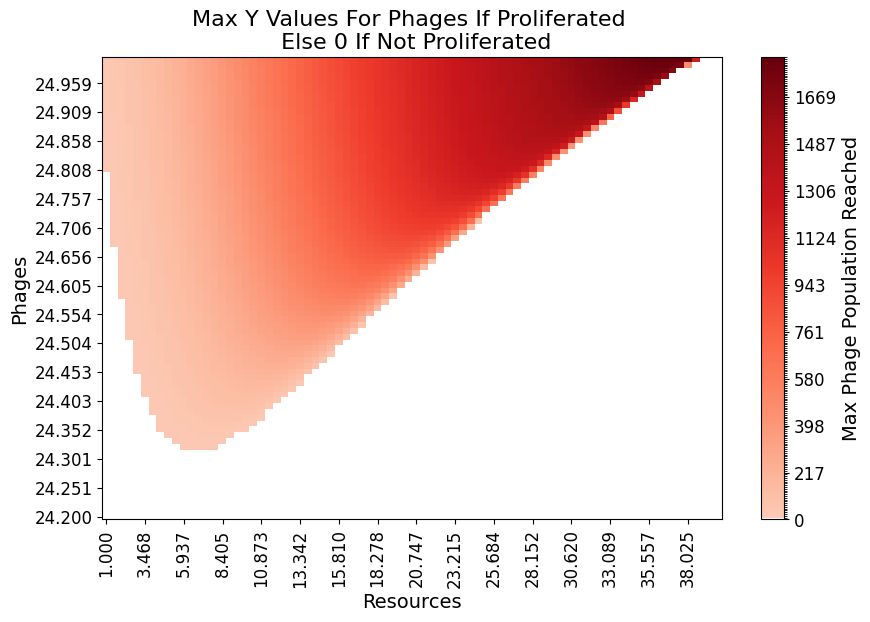

In [ ]:
parquet_file_path = 'SimulationResults/UltimateAnalysis/PhasePortraitResourcesPhage2/PhasePortraitResourcesPhage2.parquet'
pickle_file_path = 'SimulationResults/UltimateAnalysis/PhasePortraitResourcesPhage2/PhasePortraitResourcesPhage2.pickle'
# PhasePortraitResourcesPhage2
with open(pickle_file_path, 'rb') as f:
    pickle_data = pickle.load(f)
print("parameter_names_used", pickle_data['parameter_names_used'])
print("param_values_list_combination", pickle_data['param_values_list_combination'])
print('partition_data', pickle_data['agent_type_count'])
print("agent_type", pickle_data['agent_type'])
print("agent_names", pickle_data['agent_names'])

ddf = dd.read_parquet(parquet_file_path, engine='pyarrow', 
                      include_partition_columns=True, 
                      gather_statistics=True, 
                      dtype_backend='pyarrow')
matrix3, matrix4 = analyze_matrix(pickle_data)
create_plot(matrix3, matrix4, pickle_data, save_fig='phase_portrait_resources_phage_2.png', plot_curve_fit=False)
